# Defining Prediction Tasks for Biomedical Text Mining

In [1]:
import json
import pandas as pd

# location for the datasets
data_dir = "./baseline/data"

## Loading PubMed Toxicogenomics Dataset

In [2]:
# PubMed training dataset from PubTator
with open(data_dir + "/train.json") as f:
    train_json = json.loads(f.read())

# validation split of 1521 examples (2%)
with open(data_dir + "/valid.json") as f:
    valid_json = json.loads(f.read())

# manually curated by biologists (1939)
with open(data_dir + "/test.json") as f:
    test_json = json.loads(f.read())

In [3]:
for doc in valid_json:
    title_length = len(doc['title'])
    for entity in doc['entity']:
        entity['label'] = entity.pop('type')

for doc in test_json:
    title_length = len(doc['title'])
    for entity in doc['entity']:
        entity['label'] = entity.pop('type')

In [4]:
# toxicogenomics interactions that are annotated in the dataset 
relation_map = json.loads(open(data_dir + "/relation_map.json").read())

In [5]:
relation_map

{'chem_disease:marker/mechanism': 0,
 'chem_disease:therapeutic': 1,
 'chem_gene:increases^expression': 2,
 'chem_gene:decreases^expression': 3,
 'gene_disease:marker/mechanism': 4,
 'chem_gene:increases^activity': 5,
 'chem_gene:decreases^activity': 6,
 'chem_gene:increases^metabolic_processing': 7,
 'chem_gene:affects^binding': 8,
 'chem_gene:increases^transport': 9,
 'chem_gene:decreases^metabolic_processing': 10,
 'chem_gene:affects^localization': 11,
 'chem_gene:affects^expression': 12,
 'gene_disease:therapeutic': 13}

## Entity Recognition

In [6]:
from spacy import displacy

doc = test_json[525] # select

doc_dict = {
    "title": doc['title'],
    "text": doc['title']+" "+doc['abstract'],
    "ents": doc['entity']
    }

entity_colors = {
    "Chemical": "#E9DF85", "Disease": "#ff6961", "Gene": "#85C1E9"
    }

displacy.render(doc_dict, manual=True, style="ent",
                 options={"colors": entity_colors})

In [7]:
doc['relation']

[{'type': 'chem_disease:therapeutic',
  'subj': 'MESH:D003915',
  'obj': 'MESH:D056486'},
 {'type': 'chem_disease:marker/mechanism',
  'subj': 'MESH:D005688',
  'obj': 'MESH:D018805'},
 {'type': 'chem_disease:marker/mechanism',
  'subj': 'MESH:D005688',
  'obj': 'MESH:D056486'}]

## Relation Extraction

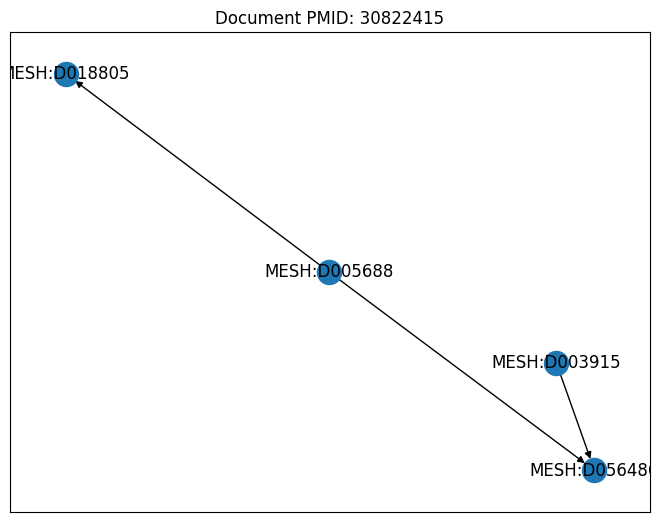

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

source, target, relations = [], [], []

for rel in doc['relation']:
    source.append(rel['subj'])
    target.append(rel['obj'])
    relations.append(rel['type'])
    
graph_df = pd.DataFrame({'source_id':source, 
        'target_id':target, 'edge_id':relations})

G=nx.from_pandas_edgelist(graph_df, "source_id", "target_id", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

pos = nx.spring_layout(G, seed=42)

nx.draw(G, with_labels=True, pos=pos)
plt.title('Document PMID: '+doc['docid'])
plt.axis('on')

plt.show()

## Manual Curation

Construct a network representation from the corpus of 523 abstracts, with entity mentions from PubTator Central that were *manually curated* by a team of biologists.

In [9]:
# collect information for network analysis
docids, source, target, relations = [], [], [], []
e1_names, e2_names, e1_type, e2_type = [], [], [], []

for doc in test_json:
    for rel in doc['relation']:
        docids.append(doc['docid'])
        source.append(rel['subj'])
        # 
        result = [item for item in doc['entity'] if item['id'] == rel['subj']]
        e1_names.append(result[0]['mention'])
        e1_type.append(result[0]['label'])

        target.append(rel['obj'])

        result = [item for item in doc['entity'] if item['id'] == rel['obj']]
        e2_names.append(result[0]['mention'])
        e2_type.append(result[0]['label'])

        relations.append(rel['type'])
    

# constructing a knowledge graph 
kg_df = pd.DataFrame({'document': docids, 'source_id':source, 'source_name': e1_names, 'source_type': e1_type,
                        'target_id':target, 'target_name': e2_names, 'target_type': e2_type,
                         'edge_id':relations})

In [15]:
kg_df[['edge_id', 'source_id', 'target_id', 'document']] # edge list

,edge_id,source_id,target_id,document
0,chem_gene:decreases^activity,MESH:C103505,1268,29883990
1,chem_gene:increases^expression,MESH:C103505,4313,29883990
2,gene_disease:marker/mechanism,3569,MESH:D001249,29902480
3,chem_disease:marker/mechanism,MESH:D013311,MESH:D005355,29953732
4,chem_gene:increases^expression,MESH:D001564,595,30020114
...,...,...,...,...
5111,chem_gene:increases^transport,MESH:D010126,2321,33146391
5112,chem_gene:decreases^expression,MESH:D010126,4319,33146391
5113,chem_gene:increases^expression,MESH:D008070,5742,33149750
5114,chem_disease:marker/mechanism,MESH:D002104,MESH:D009765,33259630


In [14]:
# aggregate node list
kg_df[['source_id', 'source_name', 'source_type']]
kg_df[['target_id', 'target_name', 'target_type']]

,target_id,target_name,target_type
0,1268,CB1,Gene
1,4313,matrix metalloproteinase (MMP) 2,Gene
2,MESH:D001249,asthma,Disease
3,MESH:D005355,fibrosis,Disease
4,595,cyclinD1,Gene
...,...,...,...
5111,2321,FMS-like tyrosine kinase-1,Gene
5112,4319,mmp10,Gene
5113,5742,cyclooxygenase-1,Gene
5114,MESH:D009765,obesity,Disease


In [10]:
kg_df.to_csv(data_dir + "/test_kg.txt", sep='\t', index=False)

In [11]:
# What can i do with this graph?
# 1. Analyze clusters in the gene-disease network
# 2. Align parts of the network with Wikipathways